In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
import shap


c:\Users\omara\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("E:/New SW PR/backend/Ignored datasets/rockyou_cleaned_target_ready.csv", encoding="utf-8",keep_default_na=False)

C:\Users\omara\AppData\Local\Temp\ipykernel_13800\3049261741.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("E:/New SW PR/backend/Ignored datasets/rockyou_cleaned_target_ready.csv", encoding="utf-8",keep_default_na=False)


In [3]:
df.shape

(14260073, 38)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14260073 entries, 0 to 14260072
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   password                        object 
 1   length                          int64  
 2   num_upper                       int64  
 3   num_lower                       int64  
 4   num_digits                      int64  
 5   num_special_char                int64  
 6   first_is_upper                  int64  
 7   first_is_digit                  int64  
 8   first_is_special                int64  
 9   last_is_upper                   int64  
 10  last_is_digit                   int64  
 11  last_is_special                 int64  
 12  length_adjusted_entropy         float64
 13  bigram_entropy                  float64
 14  combined_entropy_pca_norm       float64
 15  digit_spread                    float64
 16  letter_spread                   float64
 17  special_spread           

In [5]:
df["zxcvbn_log10_guesses"]

0            0.30103
1           0.845098
2           0.778151
3           0.477121
4           1.681241
              ...   
14260068    1.079181
14260069    6.556605
14260070         6.0
14260071        10.0
14260072    6.004321
Name: zxcvbn_log10_guesses, Length: 14260073, dtype: object

In [6]:
df['zxcvbn_log10_guesses'] = pd.to_numeric(
    df['zxcvbn_log10_guesses'],
    errors='coerce'
)
df["zxcvbn_log10_guesses"]


0            0.301030
1            0.845098
2            0.778151
3            0.477121
4            1.681241
              ...    
14260068     1.079181
14260069     6.556605
14260070     6.000000
14260071    10.000000
14260072     6.004321
Name: zxcvbn_log10_guesses, Length: 14260073, dtype: float64

In [7]:
df['zxcvbn_log10_guesses'].isna().sum()

np.int64(142)

In [8]:
df = df.dropna(subset=['zxcvbn_log10_guesses'])

In [9]:
df.isna().sum()

password                          0
length                            0
num_upper                         0
num_lower                         0
num_digits                        0
num_special_char                  0
first_is_upper                    0
first_is_digit                    0
first_is_special                  0
last_is_upper                     0
last_is_digit                     0
last_is_special                   0
length_adjusted_entropy           0
bigram_entropy                    0
combined_entropy_pca_norm         0
digit_spread                      0
letter_spread                     0
special_spread                    0
num_consecutive_digit_runs        0
num_consecutive_letter_runs       0
num_consecutive_upper_runs        0
num_consecutive_special_runs      0
letter_to_digit                   0
digit_to_letter                   0
alternating_pattern_score         0
transitions_to_length_ratio       0
longest_same_char_streak          0
digit_letter_mixing_score   

In [10]:
num_df = df.select_dtypes(include=[np.number])
np.isinf(num_df).sum()


length                                0
num_upper                             0
num_lower                             0
num_digits                            0
num_special_char                      0
first_is_upper                        0
first_is_digit                        0
first_is_special                      0
last_is_upper                         0
last_is_digit                         0
last_is_special                       0
length_adjusted_entropy               0
bigram_entropy                        0
combined_entropy_pca_norm             0
digit_spread                          0
letter_spread                         0
special_spread                        0
num_consecutive_digit_runs            0
num_consecutive_letter_runs           0
num_consecutive_upper_runs            0
num_consecutive_special_runs          0
letter_to_digit                       0
digit_to_letter                       0
alternating_pattern_score             0
transitions_to_length_ratio           0


In [11]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [12]:
num_df = df.select_dtypes(include=[np.number])
np.isinf(num_df).sum()

length                            0
num_upper                         0
num_lower                         0
num_digits                        0
num_special_char                  0
first_is_upper                    0
first_is_digit                    0
first_is_special                  0
last_is_upper                     0
last_is_digit                     0
last_is_special                   0
length_adjusted_entropy           0
bigram_entropy                    0
combined_entropy_pca_norm         0
digit_spread                      0
letter_spread                     0
special_spread                    0
num_consecutive_digit_runs        0
num_consecutive_letter_runs       0
num_consecutive_upper_runs        0
num_consecutive_special_runs      0
letter_to_digit                   0
digit_to_letter                   0
alternating_pattern_score         0
transitions_to_length_ratio       0
longest_same_char_streak          0
digit_letter_mixing_score         0
contains_dictionary_word    

#this one should have been droped in the cleaning phase

In [14]:
drop_cols = [
    "PCFG_probability", 
    "contains_name" 
]
df = df.drop(columns=drop_cols)

In [17]:
df.columns

Index(['password', 'length', 'num_upper', 'num_lower', 'num_digits',
       'num_special_char', 'first_is_upper', 'first_is_digit',
       'first_is_special', 'last_is_upper', 'last_is_digit', 'last_is_special',
       'length_adjusted_entropy', 'bigram_entropy',
       'combined_entropy_pca_norm', 'digit_spread', 'letter_spread',
       'special_spread', 'num_consecutive_digit_runs',
       'num_consecutive_letter_runs', 'num_consecutive_upper_runs',
       'num_consecutive_special_runs', 'letter_to_digit', 'digit_to_letter',
       'alternating_pattern_score', 'transitions_to_length_ratio',
       'longest_same_char_streak', 'digit_letter_mixing_score',
       'contains_dictionary_word', 'longest_dictionary_word_length',
       'dictionary_coverage_ratio', 'contains_common_name', 'contains_year',
       'zxcvbn_log10_guesses', 'omen_log10', 'pcfg_neglog10_prob'],
      dtype='object')

In [18]:
df.shape

(14214449, 36)

Scale pcfg_neglog10_prob to be 0-10 score

In [51]:
from sklearn.preprocessing import QuantileTransformer

to_be_scaled_col = "pcfg_neglog10_prob"
scaled_col = "pcfg_neglog10_scaled"

qt = QuantileTransformer(output_distribution='uniform', random_state=42)

df[scaled_col] = qt.fit_transform(df[[to_be_scaled_col]]) * 10


In [55]:
# Get 100 random rows
sample = df.sample(20)

# Show only these columns
print(sample[['password', 'omen_log10', 'pcfg_neglog10_prob', 'pcfg_neglog10_scaled']])

               password  omen_log10  pcfg_neglog10_prob  pcfg_neglog10_scaled
7362268      ilovefang1    1.041393            9.357743              5.736079
6879235     johnxbox360    1.204120           12.550848              8.761344
4668103       phantetic    1.113943            7.754264              2.667668
6077625        logan$$$    1.079181            9.161590              5.419353
1266405        solroas1    1.146128            8.814544              4.919920
12267603         460280    0.845098            7.691305              2.377377
13991679         03gs5u    1.230449           12.585415              8.776158
2405508      0844512277    1.079181            7.403611              0.580581
2081335         TONGA11    1.079181            8.646530              4.676182
604606           ohio29    0.954243            7.943583              3.436447
9034655   christy_moore    1.278754           12.155610              8.527378
7192892         j916675    1.079181            9.817386         

In [57]:
# Create bins for the scaled values
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Count values in each range
counts = {}
for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    if i == len(bins)-2:  # Last bin includes upper bound
        count = len(df[(df['pcfg_neglog10_scaled'] >= lower) & (df['pcfg_neglog10_scaled'] <= upper)])
    else:
        count = len(df[(df['pcfg_neglog10_scaled'] >= lower) & (df['pcfg_neglog10_scaled'] < upper)])
    counts[f'{lower}-{upper}'] = count

# Print counts
for range_str, count in counts.items():
    print(f'{range_str}: {count} values')


0-1: 1322665 values
1-2: 1643462 values
2-3: 1426494 values
3-4: 1431710 values
4-5: 1407009 values
5-6: 1360962 values
6-7: 1479392 values
7-8: 1464484 values
8-9: 1287156 values
9-10: 1391115 values


In [58]:
target_col = "pcfg_neglog10_scaled"

# Drop non-feature columns 
drop_cols = [
    "password",
    "pcfg_neglog10_prob",
    "pcfg_neglog10_scaled"  
]

X = df.drop(columns=drop_cols)
y = df[target_col]

# List of feature names
features = X.columns.tolist()

Split

In [59]:
def create_regression_split(X, y, test_size=0.15, val_size=0.15, random_state=42):

    print("\n" + "=" * 60)
    print("CREATING STRATIFIED 3-WAY SPLIT")
    print("=" * 60)
    
    # Create 5 bins for stratification
    y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
    
    # First split: Train+Val vs Test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y_binned
    )
    
    # Re-bin for second split
    y_temp_binned = pd.qcut(y_temp, q=5, labels=False, duplicates='drop')
    
    # Second split: Train vs Validation
    val_adj = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_adj,
        random_state=random_state,
        stratify=y_temp_binned
    )
    
    # Create DMatrices for XGBoost (CPU)
    print("\nCreating DMatrices for XGBoost (CPU)...")
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    # Split statistics
    print(f"\nSplit Statistics:")
    print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    
    # Target distribution in each split
    print("\nTarget Value Ranges:")
    splits = [("Train", y_train), ("Validation", y_val), ("Test", y_test)]
    for name, y_data in splits:
        print(f"  {name}: [{y_data.min():.4f}, {y_data.max():.4f}], Mean: {y_data.mean():.4f}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, dtrain, dval, dtest

# Create splits
X_train, X_val, X_test, y_train, y_val, y_test, dtrain, dval, dtest = create_regression_split(
    X, y, 
    test_size=0.15,
    val_size=0.15
)


CREATING STRATIFIED 3-WAY SPLIT

Creating DMatrices for XGBoost (CPU)...

Split Statistics:
  Train:      9,950,113 samples (70.0%)
  Validation: 2,132,168 samples (15.0%)
  Test:       2,132,168 samples (15.0%)

Target Value Ranges:
  Train: [0.0000, 10.0000], Mean: 4.9389
  Validation: [0.0000, 10.0000], Mean: 4.9387
  Test: [0.0000, 10.0000], Mean: 4.9386


XGBoost Model Training with Early Stopping


TRAINING XGBOOST REGRESSION MODEL (CPU)

Training Parameters:
  objective: reg:squarederror
  eval_metric: ['rmse', 'mae']
  max_depth: 6
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  learning_rate: 0.1
  n_estimators: 1000
  reg_alpha: 0
  reg_lambda: 1
  gamma: 0
  seed: 42
  tree_method: hist
  device: cpu


c:\Users\omara\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:23:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:2.68735	train-mae:2.32647	validation-rmse:2.68710	validation-mae:2.32627
[50]	train-rmse:1.31990	train-mae:0.86908	validation-rmse:1.32060	validation-mae:0.86959
[100]	train-rmse:1.29929	train-mae:0.84475	validation-rmse:1.30018	validation-mae:0.84533
[150]	train-rmse:1.29027	train-mae:0.83326	validation-rmse:1.29148	validation-mae:0.83403
[200]	train-rmse:1.28433	train-mae:0.82568	validation-rmse:1.28581	validation-mae:0.82662
[250]	train-rmse:1.28003	train-mae:0.82033	validation-rmse:1.28176	validation-mae:0.82140
[300]	train-rmse:1.27708	train-mae:0.81682	validation-rmse:1.27906	validation-mae:0.81800
[350]	train-rmse:1.27436	train-mae:0.81313	validation-rmse:1.27661	validation-mae:0.81443
[400]	train-rmse:1.27212	train-mae:0.81045	validation-rmse:1.27461	validation-mae:0.81186
[450]	train-rmse:1.27044	train-mae:0.80823	validation-rmse:1.27322	validation-mae:0.80976
[500]	train-rmse:1.26858	train-mae:0.80608	validation-rmse:1.27159	validation-mae:0.80771
[550]	train-r

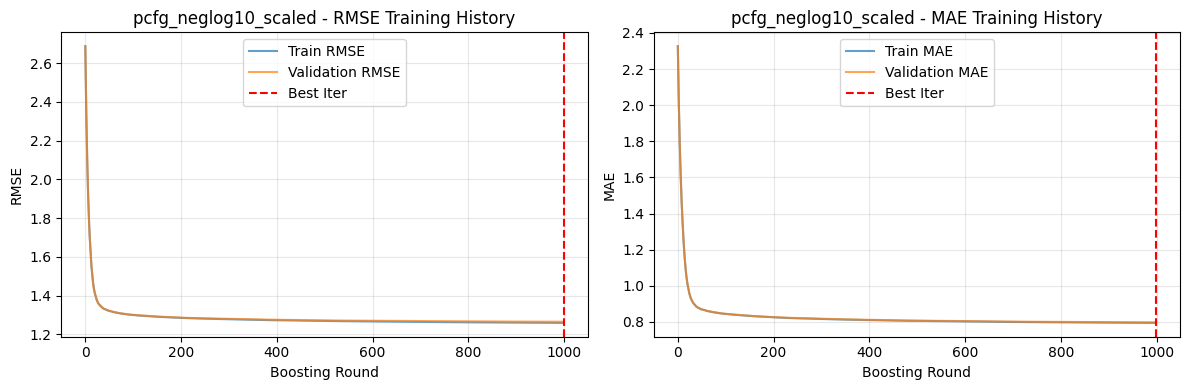

In [60]:
def train_xgboost_regression(dtrain, dval, target_name):
    """
    Train XGBoost regression model on CPU with early stopping
    """
    print("\n" + "=" * 60)
    print("TRAINING XGBOOST REGRESSION MODEL (CPU)")
    print("=" * 60)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse', 'mae'],
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'gamma': 0,
        'seed': 42,
        'tree_method': 'hist',  # CPU-only
        'device': 'cpu'         # Force CPU
    }
    
    print("\nTraining Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    evals_result = {}
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=50,
        evals_result=evals_result,
        verbose_eval=50
    )
    
    print(f"\nTraining stopped at round {model.best_iteration}")
    print(f"Best validation score: {model.best_score:.6f}")
    
    # Plot RMSE and MAE
    if len(evals_result['validation']['rmse']) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # RMSE
        axes[0].plot(evals_result['train']['rmse'], label='Train RMSE', alpha=0.7)
        axes[0].plot(evals_result['validation']['rmse'], label='Validation RMSE', alpha=0.7)
        axes[0].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'Best Iter')
        axes[0].set_xlabel('Boosting Round')
        axes[0].set_ylabel('RMSE')
        axes[0].set_title(f'{target_name} - RMSE Training History')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        # MAE
        axes[1].plot(evals_result['train']['mae'], label='Train MAE', alpha=0.7)
        axes[1].plot(evals_result['validation']['mae'], label='Validation MAE', alpha=0.7)
        axes[1].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'Best Iter')
        axes[1].set_xlabel('Boosting Round')
        axes[1].set_ylabel('MAE')
        axes[1].set_title(f'{target_name} - MAE Training History')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('xgboost_training_history.png', dpi=100, bbox_inches='tight')
        plt.show()
    
    return model, params

# Train model
model, params = train_xgboost_regression(dtrain, dval, target_col)

Model Evaluation & Prediction


MODEL EVALUATION ON TEST SET

Test Set Performance Metrics:
  MSE:  1.597489
  RMSE: 1.263918
  MAE:  0.797861
  R²:   0.808262

Example Predictions (first 10):
     Actual  Predicted     Error
0  6.795141   6.025686  0.769455
1  9.002643   8.549044  0.453600
2  8.926533   7.184973  1.741560
3  5.900291   5.210925  0.689366
4  5.350402   5.917031 -0.566629
5  8.072908   7.718768  0.354139
6  8.291819   7.612606  0.679214
7  3.433342   4.057318 -0.623976
8  0.580581   0.571160  0.009421
9  1.601602   1.564233  0.037368


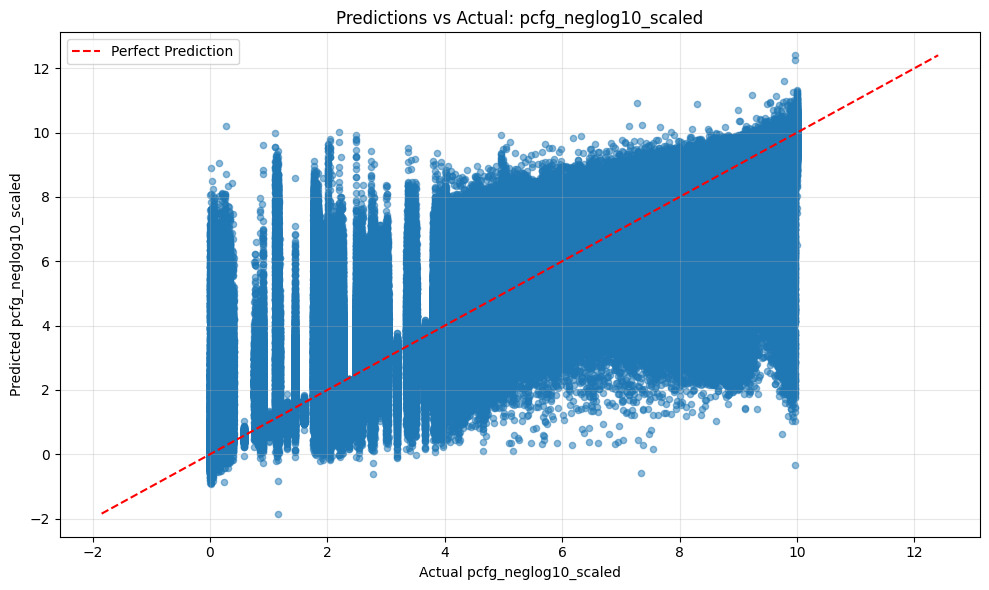

In [61]:
def evaluate_model(model, dtest, y_test, target_name):
    print("\n" + "=" * 60)
    print("MODEL EVALUATION ON TEST SET")
    print("=" * 60)
    
    y_pred = model.predict(dtest)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nTest Set Performance Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    # Example predictions
    examples = pd.DataFrame({
        'Actual': y_test.values[:10],
        'Predicted': y_pred[:10],
        'Error': y_test.values[:10] - y_pred[:10]
    })
    print("\nExample Predictions (first 10):")
    print(examples.to_string())
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, s=20)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'Predictions vs Actual: {target_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('predictions_vs_actual.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return y_pred, {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate
y_pred, metrics = evaluate_model(model, dtest, y_test, target_col)

Feature importance 


FEATURE IMPORTANCE ANALYSIS

Top 20 most important features:
                       feature  importance
          zxcvbn_log10_guesses      9314.0
                    omen_log10      7596.0
     dictionary_coverage_ratio      4986.0
longest_dictionary_word_length      4866.0
                     num_lower      4138.0
     combined_entropy_pca_norm      3728.0
                 letter_spread      3028.0
   transitions_to_length_ratio      2922.0
                        length      2874.0
                bigram_entropy      2805.0
       length_adjusted_entropy      2513.0
                  digit_spread      1761.0
                    num_digits      1593.0
                     num_upper      1339.0
          contains_common_name      1307.0
      longest_same_char_streak      1192.0
   num_consecutive_letter_runs       729.0
     alternating_pattern_score       573.0
                 last_is_digit       535.0
              num_special_char       498.0


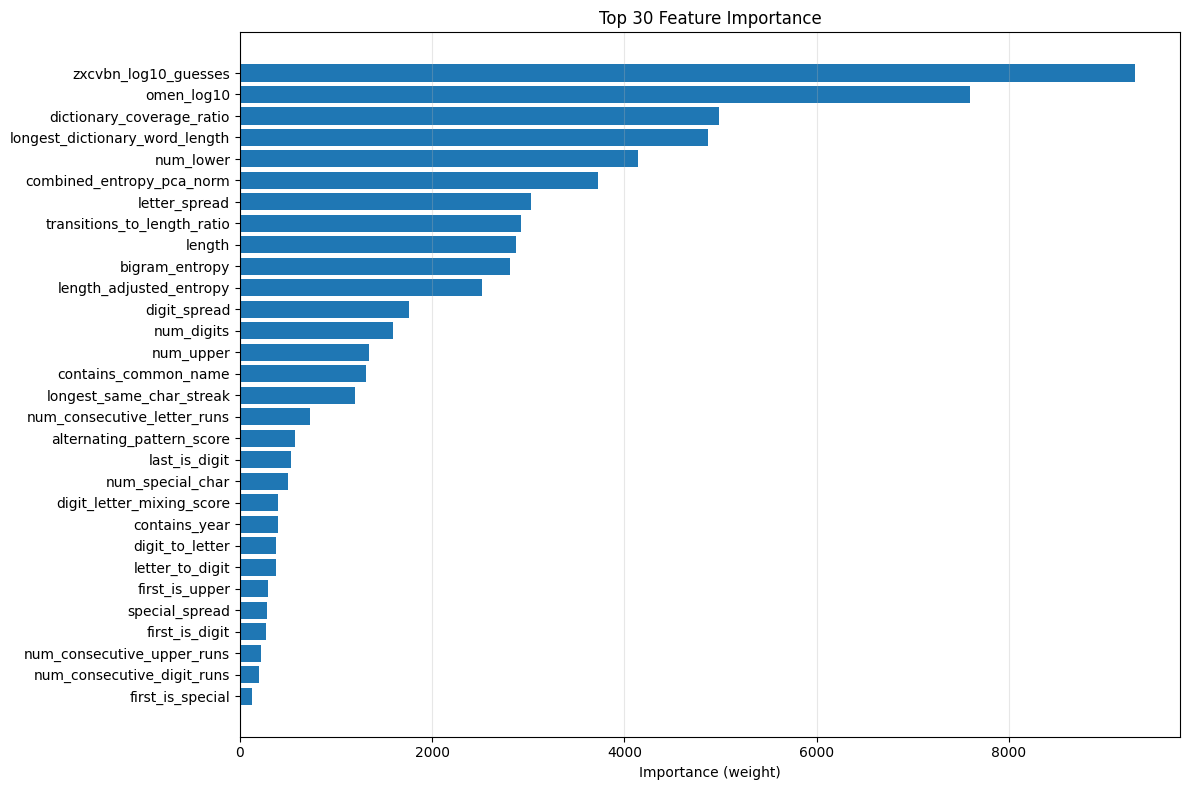

In [62]:
def analyze_feature_importance(model, features):
    """
    Analyze and visualize feature importance
    """
    print("\n" + "=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # Get feature importance
    importance_dict = model.get_score(importance_type='weight')
    
    if not importance_dict:
        print("No feature importance scores available")
        return
    
    # Convert to DataFrame
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 20 most important features:")
    print(importance_df.head(20).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    
    # Plot top 30 features
    top_n = min(30, len(importance_df))
    top_features = importance_df.head(top_n)
    
    plt.barh(range(top_n), top_features['importance'].values)
    plt.yticks(range(top_n), top_features['feature'].values)
    plt.xlabel('Importance (weight)')
    plt.title(f'Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()  # Most important on top
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return importance_df

# Analyze features
importance_df = analyze_feature_importance(model, features)


In [63]:
def save_model_and_results(model, params, metrics, importance_df, target_col, y_test, y_pred):
    print("\n" + "=" * 60)
    print("SAVING MODEL AND RESULTS")
    print("=" * 60)
    
    model.save_model(f'final_model.json')
    
    pd.DataFrame(list(params.items()), columns=['Parameter', 'Value']).to_csv(
        f'model_params.csv', index=False
    )
    
    pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value']).to_csv(
        f'model_metrics.csv', index=False
    )
    
    if importance_df is not None:
        importance_df.to_csv(f'model_feature_importance.csv', index=False)
    
    pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'error': y_test.values - y_pred
    }).to_csv(f'model_predictions.csv', index=False)
    
    print(f"All files saved with prefix 'model_'")

save_model_and_results(model, params, metrics, importance_df, target_col, y_test, y_pred)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Target: {target_col}")
print(f"Final test R²: {metrics['r2']:.4f}")


SAVING MODEL AND RESULTS


All files saved with prefix 'model_'

TRAINING COMPLETE!
Target: pcfg_neglog10_scaled
Final test R²: 0.8083


SHAP

In [64]:
model = xgb.XGBRegressor()
model.load_model("final_model.json")

In [65]:
explainer = shap.Explainer(model, X_train)

In [66]:
#note the testing is done to ensure SHAP is working proberly as it is only done using a small supset of the data
X_test_sample = X_test.sample(n=1000, random_state=42)
shap_values = explainer(X_test_sample)

 97%|=================== | 971/1000 [00:16<00:00]       

In [67]:
y_pred = model.predict(X_test)

worst_idx = np.argsort(y_pred)[:100]
X_test_worst = X_test.iloc[worst_idx]

shap_values_worst = explainer(X_test_worst)

In [68]:
best_idx = np.argsort(y_pred)[-100:]
X_test_best = X_test.iloc[best_idx]

shap_values_best = explainer(X_test_best)

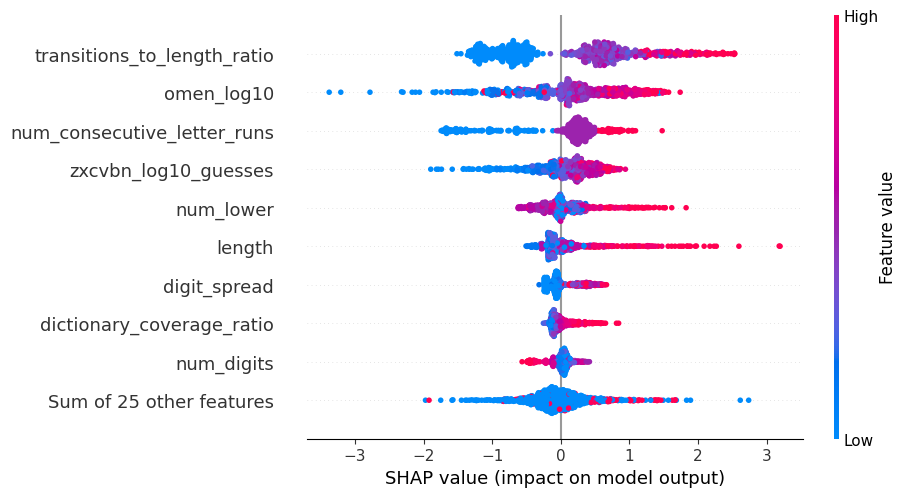

In [69]:
shap.plots.beeswarm(shap_values)

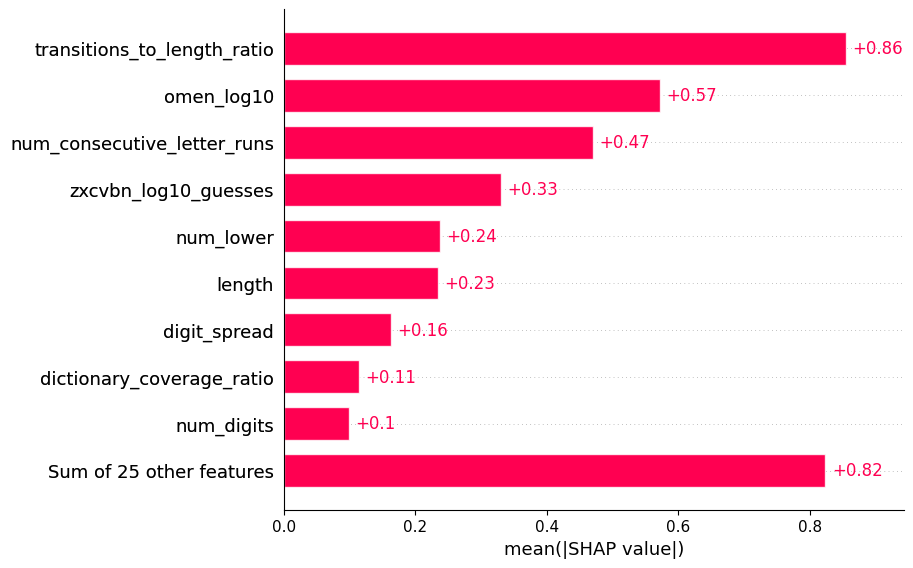

In [70]:
shap.plots.bar(shap_values)

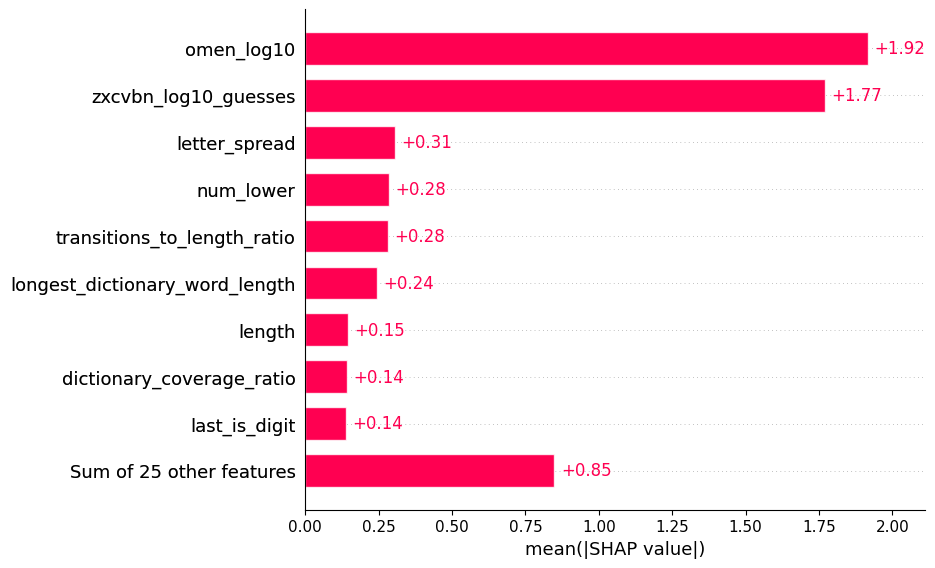

In [71]:
shap.plots.bar(shap_values_worst)

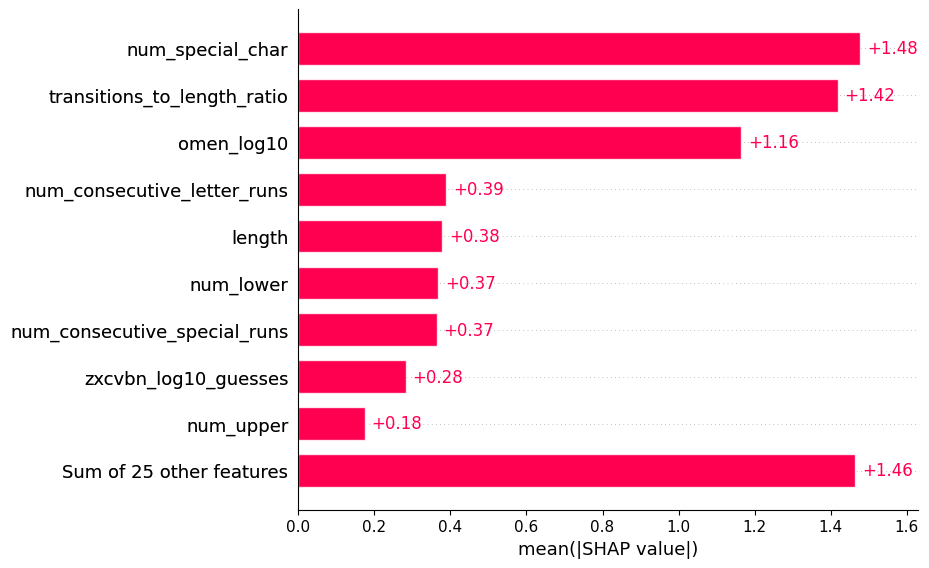

In [72]:
shap.plots.bar(shap_values_best)

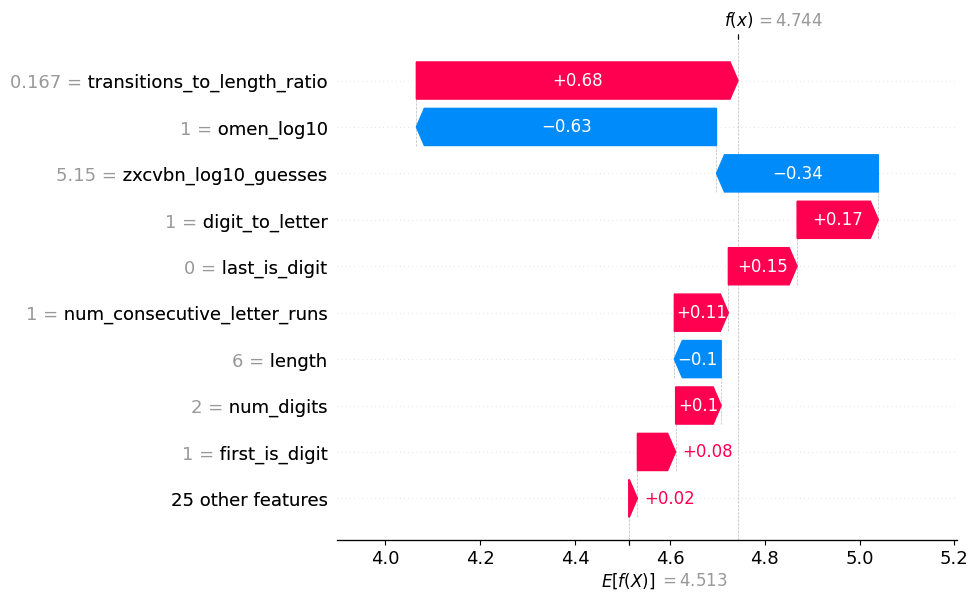

In [73]:
shap.plots.waterfall(shap_values[0])

In [74]:
pd.DataFrame(
    shap_values.values,
    columns=shap_values.feature_names
)

,length,num_upper,num_lower,num_digits,num_special_char,first_is_upper,first_is_digit,first_is_special,last_is_upper,last_is_digit,...,transitions_to_length_ratio,longest_same_char_streak,digit_letter_mixing_score,contains_dictionary_word,longest_dictionary_word_length,dictionary_coverage_ratio,contains_common_name,contains_year,zxcvbn_log10_guesses,omen_log10
0,-0.098803,-0.046600,0.035324,0.096084,-0.034811,0.017914,0.080670,0.0,-0.007267,0.145007,...,0.678495,-0.007118,0.012216,0.0,-0.039845,-0.077509,-0.043562,0.000794,-0.341417,-0.633094
1,-0.103165,-0.055393,-0.221441,0.015514,-0.037137,0.022592,-0.004875,0.0,-0.007881,-0.108046,...,0.621080,-0.008366,0.007461,0.0,0.016843,-0.018010,-0.026145,0.004138,0.602000,0.417095
2,1.959630,-0.062181,1.352811,0.067477,-0.037089,0.012005,0.050882,0.0,-0.012436,0.036238,...,-0.690007,-0.013798,0.005881,0.0,-1.046613,0.506120,0.034286,0.004107,0.160292,0.113119
3,0.108195,-0.054814,-0.275093,-0.029172,-0.034951,0.019246,-0.005295,0.0,-0.006862,-0.158266,...,0.029666,0.080413,0.003956,0.0,-0.107566,0.073236,0.151044,0.008998,-0.476815,-0.026937
4,-0.168975,-0.051069,-0.230334,-0.010124,0.578101,0.028070,0.002021,0.0,-0.011431,0.179357,...,0.892202,-0.010864,0.007454,0.0,0.021649,-0.096121,-0.016542,0.002809,0.228398,0.648384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.066810,-0.054206,-0.218458,-0.012821,-0.033514,0.023292,0.002783,0.0,-0.007286,-0.122873,...,0.395528,-0.007883,0.005237,0.0,-0.108290,-0.024413,-0.067394,0.004527,0.304936,0.272970
996,-0.123470,-0.065783,-0.439159,-0.021746,-0.039923,0.024478,-0.000413,0.0,-0.007344,-0.118665,...,0.570101,-0.013642,0.005179,0.0,-0.029672,-0.044965,-0.050254,0.003654,0.244741,0.429815
997,-0.142200,-0.048464,0.095432,-0.013308,-0.038354,0.012648,0.020904,0.0,-0.006802,-0.057168,...,1.172360,-0.021657,-0.306943,0.0,-0.034525,0.003180,-0.052009,0.004597,-0.161808,-0.608824
998,-0.281686,-0.058074,-0.041308,-0.482044,-0.055936,0.014700,-0.089958,0.0,-0.006334,-0.026009,...,-1.292038,0.017280,0.009006,0.0,0.060001,-0.081161,-0.026975,0.002650,0.242770,0.216819


Save the explainer 

In [75]:
#to avoid recreting the explainer after deployment (avoid uploading the train split to the deployment server)
with open('explainer.pkl', 'wb') as f:
    explainer.save(f)

print("explainre saved")

explainre saved
